In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [69]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
  
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other
  
    def sigmoid(self):
        x = self.data
        s = 1 / (1 + math.exp(-x))  # Sigmoid function
        out = Value(s, (self,), 'sigmoid')
        
        def _backward():
            self.grad += s * (1 - s) * out.grad  # Derivative of sigmoid
        out._backward = _backward
        
        return out
    
    def leaky_relu(self, alpha=0.01):
        x = self.data
        t = x if x > 0 else alpha * x  # Apply Leaky ReLU transformation
        out = Value(t, (self,), 'leaky_relu')

        def _backward():
            self.grad += (1 if x > 0 else alpha) * out.grad  # Derivative of Leaky ReLU
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out
  
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
  
    def relu(self):
        x = self.data
        t = max(0, x)
        out = Value(t, (self,), 'relu')
        
        def _backward():
            self.grad += (1 if x > 0 else 0) * out.grad
        out._backward = _backward
        
        return out
   
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [62]:
# Define inputs as micrograd Values
x = Value(3.0, label= 'x')  # Example value for x
y = Value(3.0, label= 'y')  # Example value for y
z = Value(0.5, label= 'z')  # Example value for z

# Build the complex expression step by step
a = x + y; a.label = 'a'                       # a = x + y
b = a**2; b.label = 'b'                        # b = (x + y)^2
c = Value.sigmoid(z); c.label = 'c'                  # c = Sigmoid(z)
d = b * c; d.label = 'd'                       # d = (x + y)^2 * Sigmoid(z)
e = Value.relu(d); e.label = 'e'                     # e = ReLU((x + y)^2 * Sigmoid(z))

f = x * y + z; f.label = 'f'                   # f = x * y + z
g = Value.tanh(f); g.label = 'g'                     # g = Tanh(x * y + z)

h = x + y + Value(1.0); h.label = 'h'          # h = x + y + 1
i = Value(math.log(h.data)); i.label = 'i'     # i = ln(x + y + 1)
j = i * z; j.label = 'j'                       # j = ln(x + y + 1) * z
k = Value.leaky_relu(j); k.label = 'k'               # k = LeakyReLU(ln(x + y + 1) * z)

t = e + g ; t.label = 't'              # f(x, y, z) = ReLU(...) + Tanh(...) - LeakyReLU(...)
L = t - k ; L.label = 'L'              # f(x, y, z) = ReLU(...) + Tanh(...) - LeakyReLU(...)
o = Value.leaky_relu(L); o.label = 'o'

In [26]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

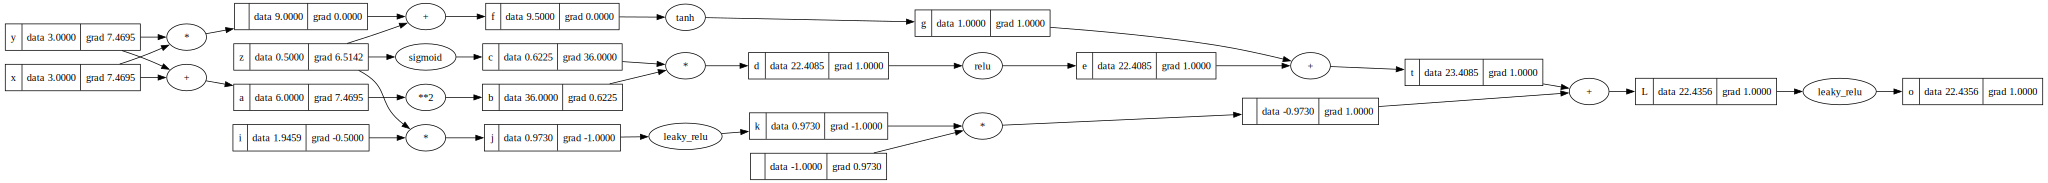

In [65]:
draw_dot(o)

In [64]:
o.backward()

In [ ]:
# Define inputs as micrograd Values
x = Value(0.5, label='x')  # Example value for x
y = Value(0.08, label='y')  # Example value for y
z = Value(2.4, label='z')  # Example value for z

# Build the complex expression step by step
a = x + y; a.label = 'a'                       # a = x + y
b = a**2; b.label = 'b'                        # b = (x + y)^2
c = Value.sigmoid(z); c.label = 'c'            # c = Sigmoid(z)
d = b / (x + Value(1.0)); d.label = 'd'        # d = (x + y)^2 / (x + 1)
e = Value.relu(d); e.label = 'e'               # e = ReLU((x + y)^2 / (x + 1))

f = x * y - z; f.label = 'f'                   # f = x * y - z
g = Value.tanh(f); g.label = 'g'               # g = Tanh(x * y - z)

h = y + Value(2.0); h.label = 'h'              # h = y + 2
i = h / z; i.label = 'i'                       # i = (y + 2) / z
j = Value.exp(i); j.label = 'j'           # j = exp((y + 2) / z)
k = Value.leaky_relu(j); k.label = 'k'         # k = LeakyReLU(exp((y + 2) / z))

m = e + g; m.label = 'm'                       # m = ReLU(...) + Tanh(...)
n = m * k; n.label = 'n'                       # n = (ReLU(...) + Tanh(...)) * LeakyReLU(...)
p = n - c; p.label = 'p'                       # p = [(ReLU(...) + Tanh(...)) * LeakyReLU(...)] - Sigmoid(z)
o = Value.tanh(p); L.label = 'L'               
o.label = 'o'                                  # o = tanh(p)


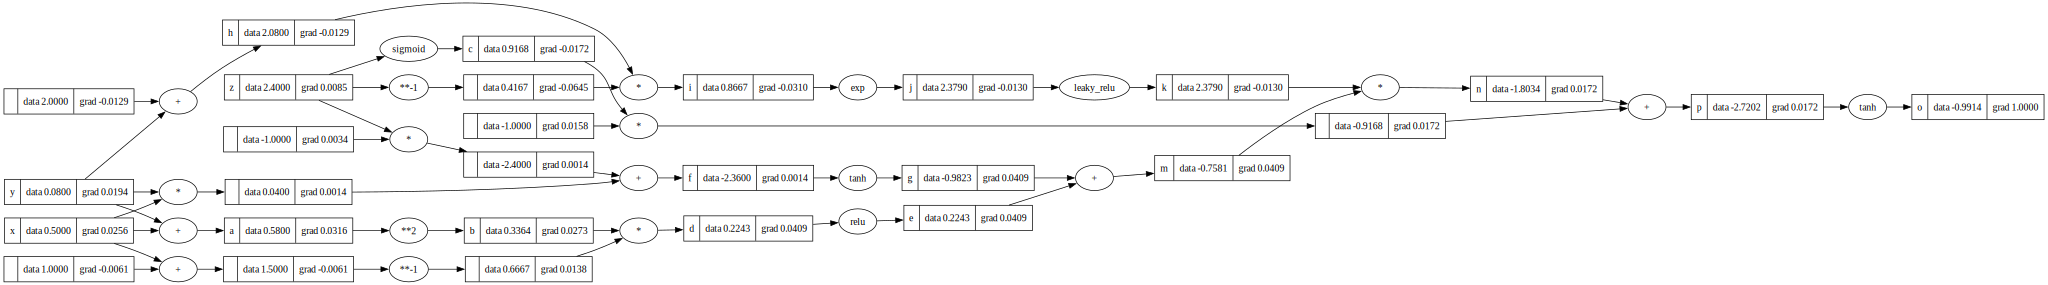

In [92]:
draw_dot(o)

In [91]:
o.backward()

In [93]:
# Define inputs as micrograd Values
x = Value(1.2, label='x')  # Example value for x
y = Value(0.9, label='y')  # Example value for y
z = Value(1.5, label='z')  # Example value for z

# Build the complex expression step by step
a = x * y; a.label = 'a'                        # a = x * y
b = z + Value(2.0); b.label = 'b'               # b = z + 2
c = a / b; c.label = 'c'                        # c = (x * y) / (z + 2)
d = Value.exp(c); d.label = 'd'                 # d = exp((x * y) / (z + 2))
e = Value.relu(d); e.label = 'e'                # e = ReLU(exp((x * y) / (z + 2)))

f = x + z; f.label = 'f'                        # f = x + z
g = Value.tanh(f); g.label = 'g'                # g = Tanh(x + z)

h = y / (x + Value(1.0)); h.label = 'h'         # h = y / (x + 1)
i = h**2; i.label = 'i'                         # i = (y / (x + 1))^2
j = Value.leaky_relu(i); j.label = 'j'          # j = LeakyReLU((y / (x + 1))^2)

k = g + j; k.label = 'k'                        # k = Tanh(...) + LeakyReLU(...)
l = e * k; l.label = 'l'                        # l = ReLU(...) * (Tanh(...) + LeakyReLU(...))
m = l + Value(3.0); m.label = 'm'               # m = ReLU(...) * (Tanh(...) + LeakyReLU(...)) + 3
n = Value.sigmoid(m); n.label = 'n'             # n = Sigmoid(...)

# Final output
o = n; o.label = 'o'                            # Final output


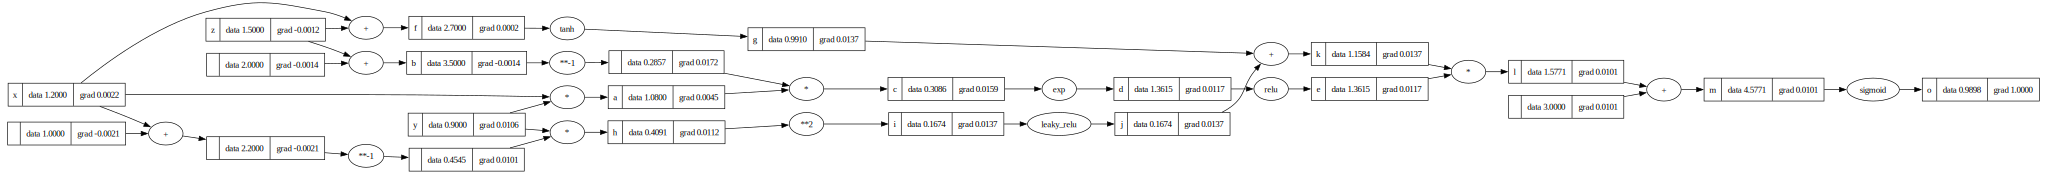

In [96]:
draw_dot(o)

In [95]:
o.backward()